In [38]:
import sys

sys.path.append("..")
import pickle as pkl
from copy import deepcopy
from dataclasses import asdict, is_dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact

from calibration.benchmark.benchmark import BenchmarkResult
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
with open("../babelcalib_results.pkl", "rb") as f:
    results = pkl.load(f)

In [26]:
results_ = sorted([r for r in results if r.error is not None], key=lambda r: r.error)

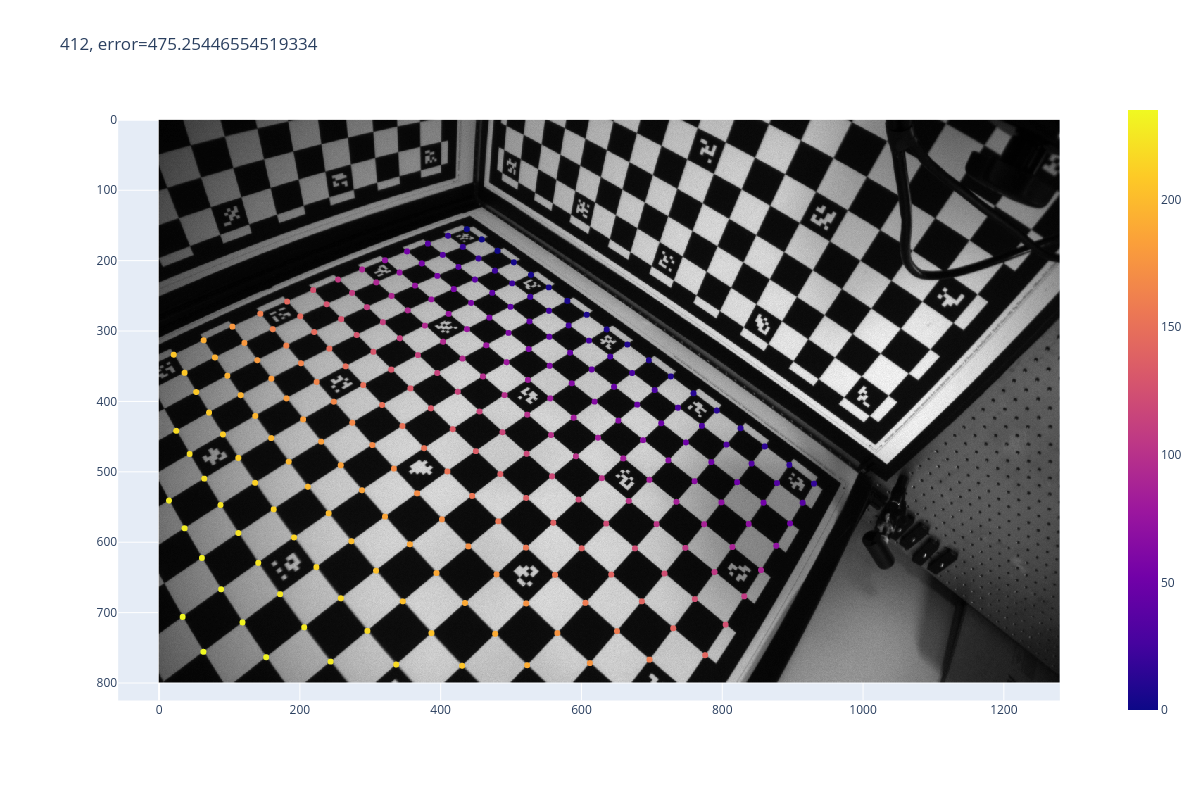

In [28]:
i = 412
r = deepcopy(results_[i])
w, h = r.input.image.size
show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    title=f"{i}, error={r.error}", height=h, width=w
)

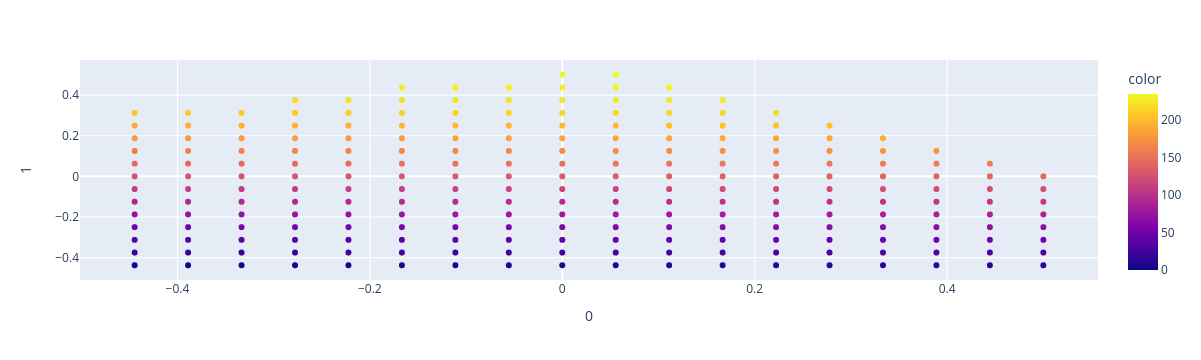

In [41]:
board = r.features.board
px.scatter(board, x=0, y=1, color=range(len(board)))

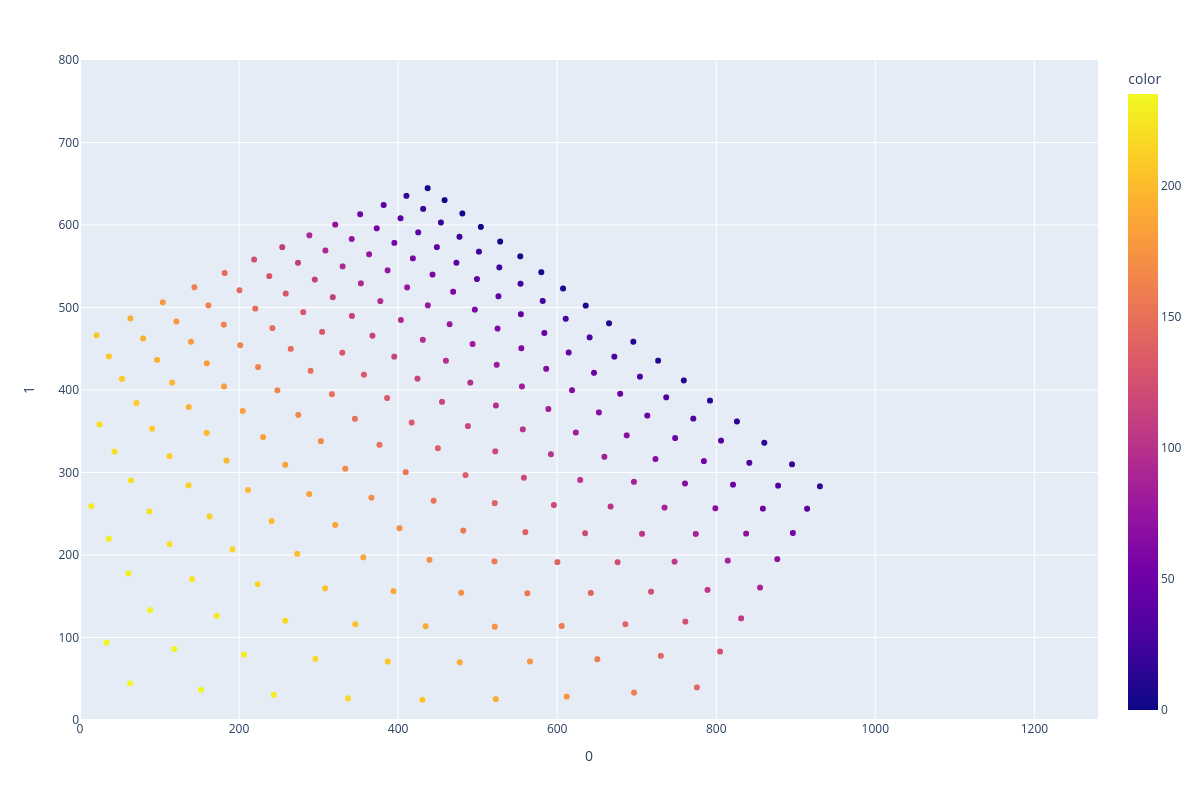

In [43]:
corners = r.features.corners.copy()
corners[:, 1] = h - corners[:, 1]
px.scatter(
    corners,
    x=0,
    y=1,
    range_x=[0, w],
    range_y=[0, h],
    color=range(len(corners)),
    height=h,
    width=w,
)

In [39]:
assert r.input.image is not None
resolution = np.array(r.input.image.size)
sensor_size = np.array([36, 36.0 * resolution[1] / resolution[0]])
focal_length = 35
camera = Camera(focal_length, resolution, sensor_size, skew=0)

In [40]:
proj_ = solve(r.features.corners, r.features.board, camera)

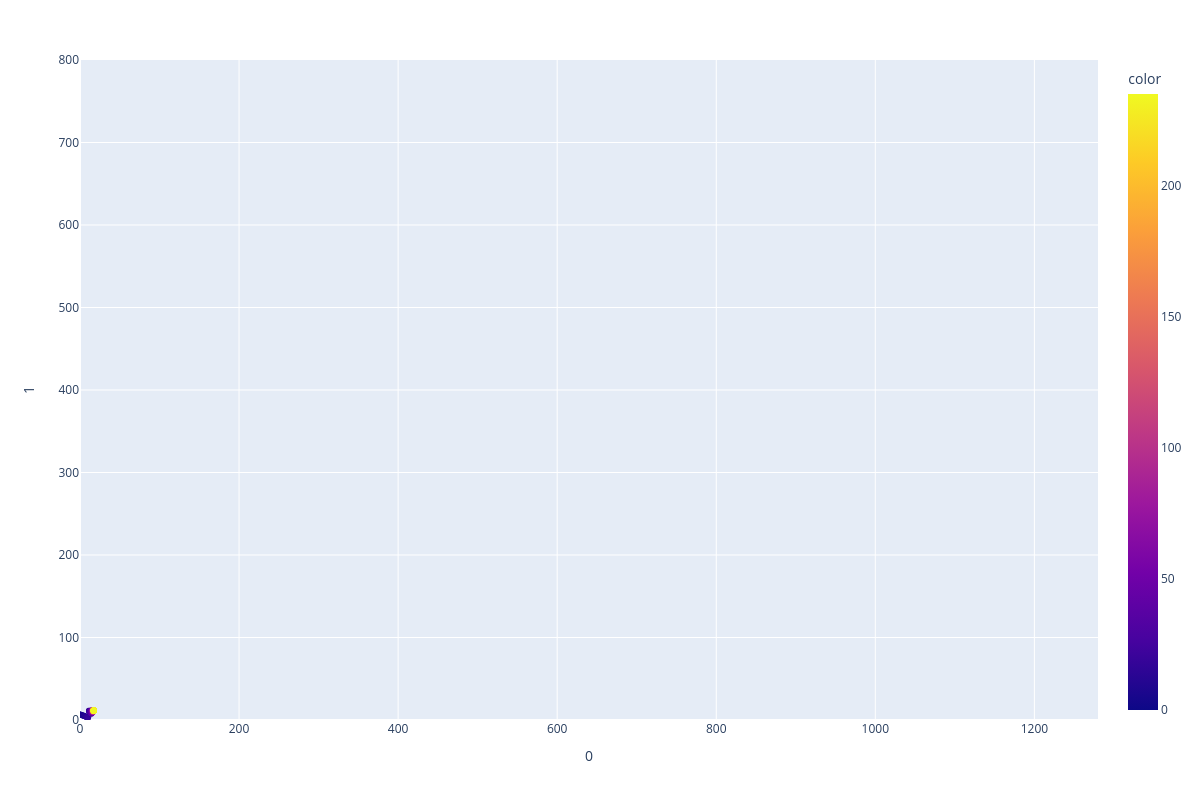

In [47]:
max_point_img_space = np.r_[camera.resolution, 1]
max_point = np.linalg.inv(camera.intrinsic_matrix) @ max_point_img_space
max_r = float(np.linalg.norm(max_point[:2]))
corners_ = proj_.project(board, max_r * 10)
px.scatter(
    corners_,
    x=0,
    y=1,
    range_x=[0, w],
    range_y=[0, h],
    color=range(len(corners)),
    height=h,
    width=w,
)